# 2 Tabular Reinforcement Learning
In this notebook we are going to explore algorithms with which we can train agents to solve more or less simple environments on their own. Specifically, we will have a look at the SARSA algorithm. Instead of telling the agents what to do explicitely, we will only punish and reward their actions. Thereby, the agents should figure out a strategy by themselves, perhaps in ways that we would not have foreseen.

Before we can start working on our agents, we have to set up an environment. The environment in a reinforcement learning problem is the world in which the agent acts. Games are very good example environments because they are sufficiently simple and can be simulated easily.

## 2.1 The environment
We will make use of the [gym](https://gym.openai.com/) library from openAI. It provides a number of environments with varying degrees of complexity in a convenient form.

In [1]:
!pip install gym

     |████████████████████████████████| 1.6 MB 3.0 MB/s eta 0:00:01
     |████████████████████████████████| 1.1 MB 8.4 MB/s eta 0:00:01
  Created wheel for gym: filename=gym-0.18.3-py3-none-any.whl size=1657515 sha256=b2ac195add22964ac7f12c558e775f5d1c9cf669bd1ad32a7bb7c7ca39a826e6
  Stored in directory: /home/matz/.cache/pip/wheels/b5/b2/22/18f5aaab5f166438bee1abb6194e5cc2602981620a7c15dbda
Successfully built gym
You should consider upgrading via the '/mnt/super_raid/uni/dais/env/bin/python -m pip install --upgrade pip' command.


In [15]:
# import stuff
import gym
from IPython import display
import time
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(1337)

In our task, we want to use the environment [Taxi-v3](https://gym.openai.com/envs/Taxi-v3/). Let's have a look (because we are using Jupyter notebooks, we need to use the supplied function below to render the environment).

In [3]:
def nb_render(env):
    # render gym environments in jupyter notebooks
    display.clear_output(wait=True)
    env.render()
    time.sleep(0.05)

In [24]:
env = gym.make('Taxi-v3')
env.reset() # resets the environment
nb_render(env)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In Taxi-V3, the agent is a taxi driver (yellow if empty, green if full) in a 5x5 square. The aim is to pick up a passenger (at the location in bold blue font) and drop the passenger off at the target location (in magenta).

__Rewards__

A successful drop-off gives a reward of 20. 
Attempting to pick-up or drop-off prematurely gives a negative reward (punishment) of -10.
Each step taken also gives a negative reward of -1.

__Actions__

In [16]:
print(env.action_space.n)

6


The agent can execute one of six actions. Move north, south, east, west, pick-up or drop-off.

__State-space__

(States are called observations in gym lingo)

We can encounter 500 different states in this environment (25 taxi positions * 5 passenger locations * 4 destination locations).

In [6]:
print(env.observation_space.n)

500


__Interaction__

Interacting with the environment is really straight-forward. Simply supply the index of an action to the step-function of the environment.
As return values, you will receive the next state, the reward for the action and if the environment is solved (you can ignore the fourth return value).

In [7]:
s, r, done, _ = env.step(3)
nb_render(env)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)


## 2.2 Evaluation of an agent
Since we want to have a _successful_ agent, we need a measure to evaluate that success. The cumulative reward over the whole episode should suffice for that purpose. An episode is the whole interaction process between agent and environment until the problem is solved or otherwise interrupted.

### Task 2.2.1 Random agent
In order to test our evaluation and compare our agent later, we need to have a baseline agent.
Since we do not know any better at the moment, let's implement an agent that acts according to a random policy.
Write a function _random\_policy()_ that takes the current state as input and returns a random action.

In [18]:
def random_policy(state):
    return np.random.randint(0, env.action_space.n)

### Task 2.2.1 Evaluation function
Write a function _evaluate()_ that takes a policy function as input, runs the policy on 20 independent episodes of the environment and returns a list of the cumulative rewards of those episodes.

_Hint_: The _reset()_ function should be run before each episode starts and provides you with the first state.

In order to see what our agent is doing, render the last episode. 

In [28]:
def evaluate(policy):
    episodes = 20
    rewards = []

    for i in range(episodes):
        s = env.reset()

        done = False
        reward_cum = 0
        
        while not done:
            action = policy(s)
            s, r, done, _ = env.step(action)
            reward_cum += r
            
            if i == 19:
                nb_render(env)
            
        rewards.append(reward_cum)
        
    return rewards

### Task 2.2.3 Evalute the random agent
Run the evaluation scheme on the random agent and plot the rewards.

In [29]:
rewards = evaluate(random_policy)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)


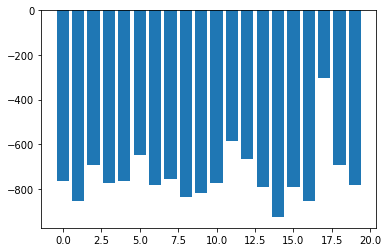

In [35]:
plt.bar(list(range(len(rewards))), rewards)
plt.show()

## 2.3 SARSA
Now we want to write an agent that learns from rewards and in the end performs the task a little better.
From the lecture, we can remember that the SARSA algorithm deals with Q values. These values tell us how good it is to take a specific action in a specific state. For descrete problems up to a certain complexity (as is the Taxi-v3) we can simply store the Q values in a table.

### Task 2.3.1 The Q-Table
Write the function _init\_table()_ that sets up and returns a table that contains the Q values of state-action pairs.
Initialise all Q values with zeros.
Over time, while learning, the agent will change these values in order to prefer certain actions in certain situations.


In [37]:
def init_table():
    return np.zeros((env.observation_space.n, env.action_space.n))

### Task 2.3.2 Exploitation: greedy strategy
The Q table represents our knowledge about the goodness of actions. Usually, we want to choose the best action for a certain situation. This way of choosing actions can be seen as exploiting your knowledge.
Write a function _exploit()_ that returns the best action for a given state according to your Q-table.

In [64]:
def exploit(state):
    best_q = np.max(table[state])
    return np.where(table[state] == best_q)[0][0]

### Task 2.3.3 Exploitation vs. Exploration
However, greedily executing actions all the time is not the best idea. A big problem in reinforcement learning is sufficent exploration of the environment. You will never know if your current strategy is optimal, if you did not fully explore all possibilities. But exploring is costly, as it means to deviate from exploiting your current strategy.

One way to tackle this dilemma is the $\epsilon$-greedy strategy. For a certain fraction of actions $\epsilon$, we will not use our knowledge to choose the best action, but rather choose a random non-greedy action to explore the environment.

Write a function _explore()_ that returns a random non-greedy action for a given state according to your Q-table.

In [66]:
def explore(state):
    best_q = np.max(table[state])
    indices_without_best = np.where(table[state] != best_q)[0]
    
    # if all are equaly bad, just choose one at random
    if len(indices_without_best) == 0:
        indices_without_best = list(range(len(table[state])))

    return np.random.choice(indices_without_best)

Write a function _eps\_greedy()_ that takes a state as input. In $\epsilon$ of all cases return an explorative action and in 1-$\epsilon$ of all cases return an exploitative action.

In [41]:
epsilon = 0.1

def eps_greedy(state):
    r = np.random.random()
    if r <= epsilon:
        return explore(state)
    else:
        return exploit(state)

### Task 2.3.1 The temporal difference error
We only need one last piece to complete our algorithm: updating our knowledge about good state-action combinations. Hence, we have to update our Q-values in a way that reflects how good an action is to reach the goal in the future.

The TD-error for SARSA is given as (see lecture p.19):

$$ \delta =  r + \gamma Q(s';a') - Q(s;a) $$

Write a function _td\_error()_, that takes as arguments the current state, the taken action, the reward, the next state and the next action and returns the temporal difference error

In [42]:
gamma = 0.99

def td_error(s, a, r, s_prime, a_prime):
    return r + (gamma * table[s_prime][a_prime]) - (table[s][a])

Lastly, the Q table needs to be updated according to:
    $$ Q(s;a) \leftarrow Q(s;a) + \eta \delta $$
    
Write a function _update\_table()_ that takes as inputs the current state, the current action and the td-error and updates the Q table.

In [43]:
eta = 0.1

def update_table(s, a, delta):
    table[s][a] = table[s][a] + (eta * delta)

## 2.4 Training
Now we can finally train our agent. 2000 episodes should suffice to sufficiently solve the Taxi problem.

The SARSA algorithm for one episode goes as follows:

- initialise environment, read initial state s
- select an action a
- repeat until done:
    - execute action $a$
    - read reward $r$ and new state $s'$
    - select next action $a'$
    - compute TD-error
    - update Q table
    - set variables for next iteration: 
        $s \leftarrow s'$, $a \leftarrow a'$

### Task 2.4.1 The train function
Write a train function that applies the SARSA algorithm to the environment for 2000 episodes. The function should return a list of cumulative rewards for each episode.

In [67]:
table = init_table()
episodes = 2000

def train():
    rewards = []
    for _ in range(episodes):
        s = env.reset()
        a = explore(s)
        r_cum = 0

        done = False
        while not done:
            s_prime, r, done, _ = env.step(a)
            r_cum += r

            a_prime = eps_greedy(s_prime)
            e_td = td_error(s, a, r, s_prime, a_prime)
            update_table(s, a, e_td)
            s = s_prime
            a = a_prime
            
        rewards.append(r_cum)

    return rewards

train_rewards = train()

### Task 2.4.2 Visualise the training
Train your agent and obtain the cumulative rewards for the episodes.
Plot the temporal evolution of the rewards over the episodes in order to see if the training worked.

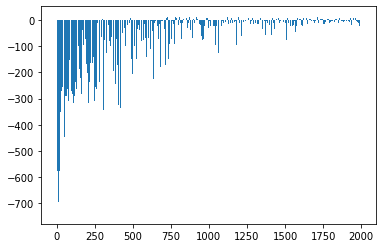

In [68]:
plt.bar(list(range(len(train_rewards))), train_rewards)
plt.show()

## 2.5 Results
Now that we have a trained agent it is time to evaluate the trained agent and compare it against the performance of the random agent.

### Task 2.5.1 Evaluate the trained agent
We already wrote the evaluation function. So now we just need to apply our policy to the environment and see how the agent performs.
It is perhaps best to just use the greedy policy. If we assume that our agent is fully trained to the best of our knowledge, and we are not updating our Q table and thus are not learning during evaluation, there is no need for exploration.

In [69]:
sarsa_rewards = evaluate(exploit)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)


### Task 2.5.2 Compare the agents
Plot the results of the random agent vs the results of the trained agent for a nice comparison.

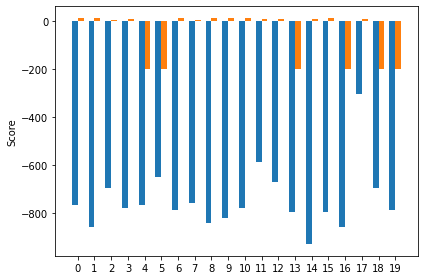

In [73]:
bar_labels = np.arange(len(rewards))
fig, ax = plt.subplots()
width = 0.35
                       
plt.bar(bar_labels - width/2, rewards, width, label='Random')
plt.bar(bar_labels + width/2, sarsa_rewards, width, label='SARSA')

ax.set_ylabel('Score')
ax.set_xticks(bar_labels)

fig.tight_layout()

plt.show()